In [24]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

#https://keras.io/examples/timeseries/timeseries_anomaly_detection/#compare-recontruction

class AnomalyDetectionConv1DAutoencoder():
    def __init__(self,df,OUTCOME = 'close', time_steps = 24, dataframe=None):
        
        training_mean = df.mean()
        training_std = df.std()
        df_training_value = (df - training_mean) / training_std
        print("Number of training samples:", len(df_training_value))
        
        self.x_train = self.create_sequences(df_training_value.values,time_steps=time_steps)
        print("Training input shape: ", self.x_train.shape)
        self.init_model(self.x_train)
        self.train(self.x_train)
        
        
    # Generated training sequences for use in the model.
    def create_sequences(self, values, time_steps=None):
        output = []
        for i in range(len(values) - time_steps + 1):
            output.append(values[i : (i + time_steps)])
        return np.stack(output)        
    
    def init_model(self,x_train):    
        self.model = keras.Sequential(
            [
                layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
                layers.Conv1D(
                    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                layers.Dropout(rate=0.2),
                layers.Conv1D(
                    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                layers.Conv1DTranspose(
                    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                layers.Dropout(rate=0.2),
                layers.Conv1DTranspose(
                    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
            ]
        )
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
        self.model.summary()

    def train(self,x_train):
        self.history = self.model.fit(
            x_train,
            x_train,
            epochs=50,
            batch_size=128,
            validation_split=0.1,
            callbacks=[
                keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
            ],
        )        

In [15]:
import os
os.environ['http_proxy'] = "http://172.30.12.56:3128" 
os.environ['https_proxy'] = "https://172.30.12.56:3128"  

master_url_root = "/home/jovyan/work/"

df_small_noise_url_suffix = "art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
print(df_small_noise_url)

df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

/home/jovyan/work/art_daily_small_noise.csv


In [33]:
anomay_enc = AnomalyDetectionConv1DAutoencoder(df_small_noise, time_steps=288)

Number of training samples: 4032
Training input shape:  (3745, 288, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_6 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_9 (Conv1DT  (None, 144, 16)          1808      
 ranspose)                                                       
                                                                 
 dropout_7 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_10 (Conv1D  (None, 288, 32)    

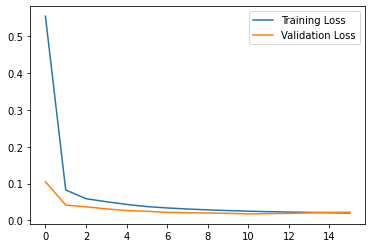

In [34]:
plt.plot(anomay_enc.history.history["loss"], label="Training Loss")
plt.plot(anomay_enc.history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

118/118 [==============================] - 1s 4ms/step


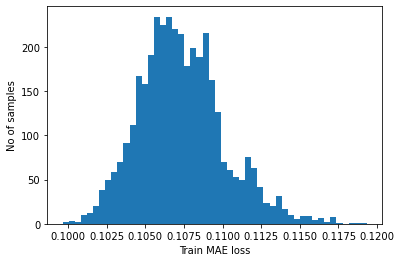

Reconstruction error threshold:  0.11933845069808838


In [35]:
# Get train MAE loss.
x_train_pred = anomay_enc.model.predict(anomay_enc.x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - anomay_enc.x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

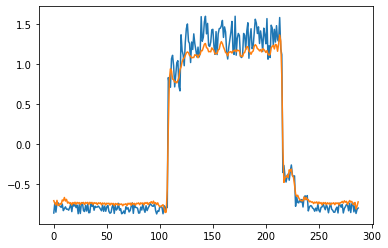

In [36]:
plt.plot(anomay_enc.x_train[0])
plt.plot(x_train_pred[0])
plt.show()

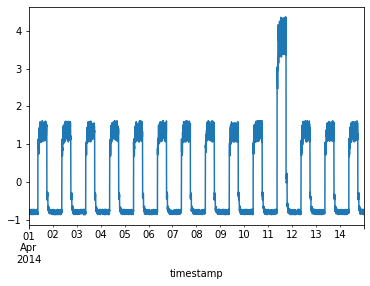

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 0s 4ms/step


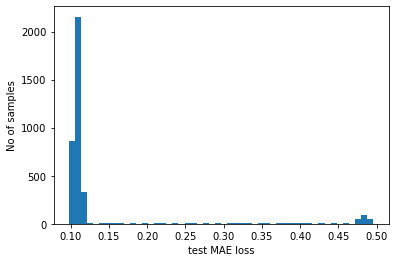

Number of anomaly samples:  423
Indices of anomaly samples:  (array([ 782,  783,  784,  786,  787,  789,  790,  794, 1646, 1650, 1651,
       1653, 1654, 1657, 1658, 1659, 1833, 1834, 1942, 2517, 2518, 2519,
       2521, 2522, 2523, 2525, 2697, 2698, 2701, 2702, 2703, 2704, 2705,
       2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716,
       2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727,
       2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738,
       2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749,
       2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760,
       2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771,
       2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782,
       2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793,
       2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804,
       2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2

In [45]:
df=df_small_noise
training_mean = df.mean()
training_std = df.std()

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = anomay_enc.create_sequences(df_test_value.values,time_steps=288)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = anomay_enc.model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [46]:
TIME_STEPS = 288
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)


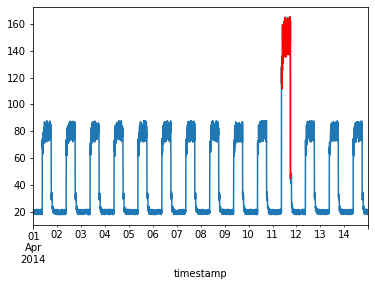

In [47]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()


In [52]:
df_small_noise


,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127
